In [34]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import scipy as sc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# data directory
DATA_DIR = os.path.join('../..', 'data')

In [35]:
data_paths = {'A': {'train': os.path.join(DATA_DIR, 'A_hhold_train.csv'), 
                    'test':  os.path.join(DATA_DIR, 'A_hhold_test.csv')}, 
              
              'B': {'train': os.path.join(DATA_DIR, 'B_hhold_train.csv'), 
                    'test':  os.path.join(DATA_DIR, 'B_hhold_test.csv')}, 
              
              'C': {'train': os.path.join(DATA_DIR, 'C_hhold_train.csv'), 
                    'test':  os.path.join(DATA_DIR, 'C_hhold_test.csv')}}

In [36]:
# load training data
a_train = pd.read_csv(data_paths['A']['train'], index_col='id')
b_train = pd.read_csv(data_paths['B']['train'], index_col='id')
c_train = pd.read_csv(data_paths['C']['train'], index_col='id')

In [37]:
# Standardize features
def standardize(df, numeric_only=True):
    numeric = df.select_dtypes(include=['int64', 'float64'])
    
    # subtracy mean and divide by std
    df[numeric.columns] = (numeric - numeric.mean()) / numeric.std()
    
    return df
    

def pre_process_data(df, enforce_cols=None):
    print("Input shape:\t{}".format(df.shape))
        

    df = standardize(df)
    print("After standardization {}".format(df.shape))
        
    # create dummy variables for categoricals
    df = pd.get_dummies(df)
    print("After converting categoricals:\t{}".format(df.shape))
    

    # match test set and training set columns
    if enforce_cols is not None:
        to_drop = np.setdiff1d(df.columns, enforce_cols)
        to_add = np.setdiff1d(enforce_cols, df.columns)

        df.drop(to_drop, axis=1, inplace=True)
        df = df.assign(**{c: 0 for c in to_add})
    
    df.fillna(0, inplace=True)

    return df

In [38]:
from sklearn.utils import resample
def balance(df):
    poor = df[df['poor'] == True]
    not_poor = df[df['poor'] == False]
    
    not_poor_downsampled = resample(not_poor, 
                              replace=True,
                              n_samples=int(len(not_poor) * 0.6),
                              random_state=42)
    
    poor_upsampled = resample(poor, 
                              replace=True,
                              n_samples=len(not_poor_downsampled),
                              random_state=42)
    res = pd.concat([poor_upsampled, not_poor_downsampled])
    return res.sample(frac=1)

In [39]:
print("Country A")
a_train.poor.fillna(False, inplace=True)
aX_train = balance(a_train)
ay_train = np.ravel(aX_train.poor.astype(int))
aX_train = pre_process_data(aX_train.drop(['poor', 'country'], axis=1))


print("\nCountry B")
b_train.poor.fillna(False, inplace=True)
bX_train = balance(b_train)
by_train = np.ravel(bX_train.poor.astype(int))
bX_train = pre_process_data(bX_train.drop(['poor', 'country'], axis=1))


print("\nCountry C")
c_train.poor.fillna(False, inplace=True)
cX_train = balance(c_train)
cy_train = np.ravel(cX_train.poor.astype(int))
cX_train = pre_process_data(cX_train.drop(['poor', 'country'], axis=1))

Country A
Input shape:	(5400, 343)
After standardization (5400, 343)
After converting categoricals:	(5400, 851)

Country B
Input shape:	(3604, 440)
After standardization (3604, 440)
After converting categoricals:	(3604, 1420)

Country C
Input shape:	(6594, 162)
After standardization (6594, 162)
After converting categoricals:	(6594, 770)


In [53]:
from sklearn.ensemble import RandomForestClassifier


def prepare_data(x, y, test_size=0.2, xgb_format=True):
    if test_size == 0:
        dtrain = x
        Y_train = y
        dtest = None
        Y_test = None
    else:
        dtrain, dtest, Y_train, Y_test = train_test_split(x, y, test_size=test_size, stratify=y, random_state=42)

    if xgb_format:
        dtrain = xgb.DMatrix(dtrain, label=Y_train)
        if dtest is not None:
            dtest = xgb.DMatrix(dtest, label=Y_test)

    return dtrain, dtest, Y_train, Y_test


def train_rf_model(features, labels, **kwargs):

    # instantiate model
    model = RandomForestClassifier(n_estimators=50, random_state=0)

    # train model
    model.fit(features, labels)

    # get a (not-very-useful) sense of performance
    accuracy = model.score(features, labels)
    print(f"In-sample accuracy: {accuracy:0.2%}")

    return model


def train_xgb_model(dtrain, deval=None, params=None, num_round=100):
    if params is None:
        params = {'max_depth': 4, 'eta': 0.01, 'silent': 1, 'objective': 'reg:logistic'}

    if deval is not None:
        bst = xgb.train(params, dtrain, num_round, evals=deval, early_stopping_rounds=500, verbose_eval=True)
    else:
        bst = xgb.train(params, dtrain, num_round, verbose_eval=True)

    return bst

# Compute loss
# -log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))
def log_loss(yt, yp):
    # yt: groundtruth
    # yp: predicted
    ground = np.array(yt)
    pred = yp.astype(float)
    eps_pred = np.maximum(np.minimum(pred, 1. - 1e-15), 1e-15)
    loss = -(ground * np.log(eps_pred) + (1 - ground) * np.log(1 - eps_pred))
    return np.mean(loss)

# Cross Validate
def cross_validate(x_train, x_test, y_train, y_test, model):
    test_loss = None
    if x_test is not None:
        preds = model.predict(x_test)
        test_loss = log_loss(preds, y_test)

    preds_train = model.predict(x_train)
    train_loss = log_loss(preds_train, y_train)
    return train_loss, test_loss

## Random Forests

In [9]:
test_size = 0.2

rf_ax_train, rf_ax_test, rf_ay_train, rf_ay_test = prepare_data(aX_train, ay_train, test_size=test_size, xgb_format=False)
rf_bx_train, rf_bx_test, rf_by_train, rf_by_test = prepare_data(bX_train, by_train, test_size=test_size, xgb_format=False)
rf_cx_train, rf_cx_test, rf_cy_train, rf_cy_test = prepare_data(cX_train, cy_train, test_size=test_size, xgb_format=False)

ValueError: Found input variables with inconsistent numbers of samples: [5400, 8203]

In [8]:
rf_a = train_rf_model(rf_ax_train, rf_ay_train)
rf_b = train_rf_model(rf_bx_train, rf_by_train)
rf_c = train_rf_model(rf_cx_train, rf_cy_train)

In-sample accuracy: 77.92%
In-sample accuracy: 100.00%
In-sample accuracy: 100.00%


In [9]:
print("A Loss. Train: {} - Test: {}".format(*cross_validate(rf_ax_train, rf_ax_test, rf_ay_train, rf_ay_test, rf_a)))
print("B Loss. Train: {} - Test: {}".format(*cross_validate(rf_bx_train, rf_bx_test, rf_by_train, rf_by_test, rf_b)))
print("C Loss. Train: {} - Test: {}".format(*cross_validate(rf_cx_train, rf_cx_test, rf_cy_train, rf_cy_test, rf_c)))

A Loss. Train: 7.626831012674126 - Test: 8.629536036664236
B Loss. Train: 9.992007221626413e-16 - Test: 2.4936394347812465
C Loss. Train: 9.992007221626413e-16 - Test: 0.32030395109214166


In [32]:
def make_country_sub(preds, test_feat, country):
    # make sure we code the country correctly
    country_codes = ['A', 'B', 'C']
    
    # get just the poor probabilities
    country_sub = pd.DataFrame(data=preds,
                               columns=['poor'], 
                               index=test_feat.index)

    
    # add the country code for joining later
    country_sub["country"] = country
    return country_sub[["country", "poor"]]


def prepare_submission(data_paths, models, enforce_cols=None, to_keep_cols=None, xgb_format=False):
    # load test data
    a_test = pd.read_csv(data_paths['A']['test'], index_col='id')
    b_test = pd.read_csv(data_paths['B']['test'], index_col='id')
    c_test = pd.read_csv(data_paths['C']['test'], index_col='id')

    if to_keep_cols:
        a_test = a_test[to_keep_cols['a']]
        b_test = b_test[to_keep_cols['b']]
        c_test = c_test[to_keep_cols['c']]

    if enforce_cols:
        # process the test data
        a_test = pre_process_data(a_test, enforce_cols=enforce_cols['a'])
        b_test = pre_process_data(b_test, enforce_cols=enforce_cols['b'])
        c_test = pre_process_data(c_test, enforce_cols=enforce_cols['c'])

    a_test.fillna(0, inplace=True)
    b_test.fillna(0, inplace=True)
    c_test.fillna(0, inplace=True)

    if xgb_format:
        a_test = xgb.DMatrix(a_test)
        b_test = xgb.DMatrix(b_test)
        c_test = xgb.DMatrix(c_test)

    # TODO: use probabilities
    a_preds = models['a'].predict(a_test)
    b_preds = models['b'].predict(b_test)
    c_preds = models['c'].predict(c_test)
    
    a_sub = make_country_sub(a_preds, a_test, 'A')
    b_sub = make_country_sub(b_preds, b_test, 'B')
    c_sub = make_country_sub(c_preds, c_test, 'C')
    
    submission = pd.concat([a_sub, b_sub, c_sub])
    
    return submission

def average_loss(losses, lenghts):
    """Returns the weighted averaged loss"""
    total_len = sum(lenghts)
    return np.average(losses, weights=[lenghts[0] / total_len, lenghts[1] / total_len, lenghts[2] / total_len])

In [68]:
# Prepare submission
models = {'a': rf_a, 'b': rf_b, 'c': rf_c}
enforce_cols = {'a': aX_train.columns, 'b': bX_train.columns, 'c': cX_train.columns}

submission = prepare_submission(data_paths, models, enforce_cols)
submission.to_csv('submission.csv')

Input shape:	(4041, 344)
After standardization (4041, 344)
After converting categoricals:	(4041, 851)
Input shape:	(1604, 441)
After standardization (1604, 441)
After converting categoricals:	(1604, 1419)
Input shape:	(3187, 163)
After standardization (3187, 163)
After converting categoricals:	(3187, 773)


## XGBoost with all the columns

In [54]:
test_size = 0.2

xgb_ax_train, xgb_ax_test, xgb_ay_train, xgb_ay_test = prepare_data(aX_train, ay_train, test_size=test_size, xgb_format=True)
xgb_bx_train, xgb_bx_test, xgb_by_train, xgb_by_test = prepare_data(bX_train, by_train, test_size=test_size, xgb_format=True)
xgb_cx_train, xgb_cx_test, xgb_cy_train, xgb_cy_test = prepare_data(cX_train, cy_train, test_size=test_size, xgb_format=True)

In [ ]:
num_round = 3000
params = {'max_depth': 9, 'eta': 0.05, 'silent': 0, 'lambda': 2, 'alpha': 1, 'lambda_bias': 1, 'min_child_weight': 2, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'seed': 42}

xgb_a = train_xgb_model(xgb_ax_train, [(xgb_ax_test, 'a_test')], params=params, num_round=num_round)
xgb_b = train_xgb_model(xgb_bx_train, [(xgb_bx_test, 'b_test')], params=params, num_round=num_round)
xgb_c = train_xgb_model(xgb_cx_train, [(xgb_cx_test, 'c_test')], params=params, num_round=num_round)

In [69]:
res = xgb_c.eval(xgb_cx_test)
res

'[0]\teval-logloss:0.016939'

In [70]:
res = xgb_b.eval(xgb_bx_test)
res

'[0]\teval-logloss:0.236981'

In [71]:
res = xgb_a.eval(xgb_ax_test)
res

'[0]\teval-logloss:0.278062'

In [72]:
a_train_loss, a_test_loss = cross_validate(xgb_ax_train, xgb_ax_test, xgb_ay_train, xgb_ay_test, xgb_a)
b_train_loss, b_test_loss = cross_validate(xgb_bx_train, xgb_bx_test, xgb_by_train, xgb_by_test, xgb_b)
c_train_loss, c_test_loss = cross_validate(xgb_cx_train, xgb_cx_test, xgb_cy_train, xgb_cy_test, xgb_c)

print("A Loss. Train: {} - Test: {}".format(a_train_loss, a_test_loss))
print("B Loss. Train: {} - Test: {}".format(b_train_loss, b_test_loss))
print("C Loss. Train: {} - Test: {}".format(c_train_loss, c_test_loss))
print("Total loss: {}".format(average_loss([a_test_loss, b_test_loss, c_test_loss], [len(aX_train), len(bX_train), len(cX_train)])))

A Loss. Train: 4.275671390682744 - Test: 5.936801740586931
B Loss. Train: 0.6499928726350537 - Test: 2.9868633920918626
C Loss. Train: 0.1036922640210429 - Test: 0.2712219623331164
Total loss: 3.3567445692880313


In [30]:
import operator
importance = xgb_a.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
dfa = pd.DataFrame(importance, columns=['feature', 'fscore'])
dfa['fscore'] = dfa['fscore'] / dfa['fscore'].sum()
dfa = dfa[dfa['fscore'] > 0.003]
len(dfa)

129

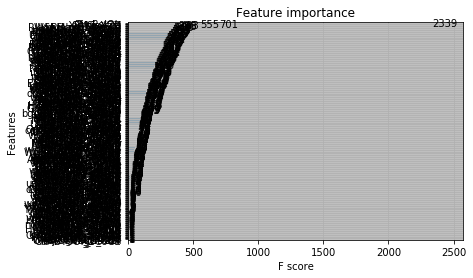

In [18]:
xgb.plot_importance(xgb_a)

In [26]:
import operator
importance = xgb_b.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
dfb = pd.DataFrame(importance, columns=['feature', 'fscore'])
dfb['fscore'] = dfb['fscore'] / dfb['fscore'].sum()
dfb = dfb[dfb['fscore'] > 0.003]
len(dfb)

86

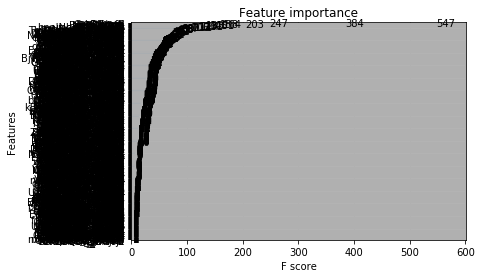

In [28]:
xgb.plot_importance(xgb_b)

In [27]:
import operator
importance = xgb_c.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
dfc = pd.DataFrame(importance, columns=['feature', 'fscore'])
dfc['fscore'] = dfc['fscore'] / dfc['fscore'].sum()
dfc = dfc[dfc['fscore'] > 0.003]
len(dfc)

50

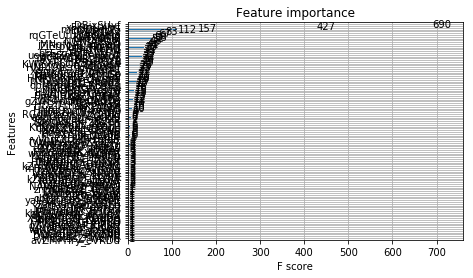

In [29]:
xgb.plot_importance(xgb_c)

## XGBoost with columns with more entropy (Submitted Jan 16 2018. Score:  0.21298 )

In [63]:
def entropy(a):
    return - sum( (a / sum(a)) * np.log((a / sum(a))))


def get_entropies(df):
    entropies = []
    for col in df.columns.tolist():
        res = df[col].value_counts()
        entropies.append(entropy(res.values))

    return entropies


def get_low_entropy_columns(df):
    to_del = []
    entropies = get_entropies(df)
    median_entr = np.median(entropies)
    #std_entr = np.std(entropies)
    #avg_entr = np.mean(entropies)
    for i, col in enumerate(df.columns.tolist()):
        if entropies[i] < median_entr:
            to_del.append(col)
    return to_del


def filter_columns(df):
    to_del = get_low_entropy_columns(df)
    print("Total columns: {}. To delete: {}".format(len(df.columns.tolist()), len(to_del)))
    to_keep = set(df.columns.tolist()) - set(to_del)
    return df[list(to_keep)]

In [64]:
# We need to repreprocess the data with less columns
print("Country A")
a_train_reduc = filter_columns(a_train.drop('poor', axis=1))
aX_train = pre_process_data(a_train_reduc)
a_train.poor.fillna(False, inplace=True)
ay_train = np.ravel(a_train.poor.astype(int))

print("\nCountry B")
b_train_reduc = filter_columns(b_train.drop('poor', axis=1))
bX_train = pre_process_data(b_train_reduc)
b_train.poor.fillna(False, inplace=True)
by_train = np.ravel(b_train.poor.astype(int))

print("\nCountry C")
c_train_reduc = filter_columns(c_train.drop('poor', axis=1))
cX_train = pre_process_data(c_train_reduc)
c_train.poor.fillna(False, inplace=True)
cy_train = np.ravel(c_train.poor.astype(int))


Country A
Total columns: 344. To delete: 172
Input shape:	(8203, 172)
After standardization (8203, 172)
After converting categoricals:	(8203, 504)

Country B
Total columns: 441. To delete: 220
Input shape:	(3255, 221)
After standardization (3255, 221)
After converting categoricals:	(3255, 936)

Country C
Total columns: 163. To delete: 81
Input shape:	(6469, 82)
After standardization (6469, 82)
After converting categoricals:	(6469, 564)


In [65]:
test_size = 0.2

xgb_ax_train, xgb_ax_test, xgb_ay_train, xgb_ay_test = prepare_data(aX_train, ay_train, test_size=test_size, xgb_format=True)
xgb_bx_train, xgb_bx_test, xgb_by_train, xgb_by_test = prepare_data(bX_train, by_train, test_size=test_size, xgb_format=True)
xgb_cx_train, xgb_cx_test, xgb_cy_train, xgb_cy_test = prepare_data(cX_train, cy_train, test_size=test_size, xgb_format=True)

In [73]:
num_round = 8000
params = {'max_depth': 3, 'eta': 0.01, 'silent': 0, 'lambda': 0.8, 'alpha': 1, 'lambda_bias': 0.5, 'min_child_weight': 2, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'seed': 42}

xgb_a = train_xgb_model(xgb_ax_train, [(xgb_ax_train, 'a_train'), (xgb_ax_test, 'a_test')], params=params, num_round=num_round)
xgb_b = train_xgb_model(xgb_bx_train, [(xgb_bx_train, 'b_train'), (xgb_bx_test, 'b_test')], params=params, num_round=num_round)
xgb_c = train_xgb_model(xgb_cx_train, [(xgb_cx_train, 'c_train'), (xgb_cx_test, 'c_test')], params=params, num_round=num_round)

In [74]:
print("A Loss. Train: {} - Test: {}".format(*cross_validate(xgb_ax_train, xgb_ax_test, xgb_ay_train, xgb_ay_test, xgb_a)))
print("B Loss. Train: {} - Test: {}".format(*cross_validate(xgb_bx_train, xgb_bx_test, xgb_by_train, xgb_by_test, xgb_b)))
print("C Loss. Train: {} - Test: {}".format(*cross_validate(xgb_cx_train, xgb_cx_test, xgb_cy_train, xgb_cy_test, xgb_c)))

A Loss. Train: 4.275671390682744 - Test: 5.936801740586931
B Loss. Train: 0.6499928726350537 - Test: 2.9868633920918626
C Loss. Train: 0.1036922640210429 - Test: 0.2712219623331164


In [75]:
# Prepare submission
models = {'a': xgb_a, 'b': xgb_b, 'c': xgb_c}
a_keep = a_train_reduc.columns.tolist()
b_keep = b_train_reduc.columns.tolist()
c_keep = c_train_reduc.columns.tolist()

#to_keep_cols = {'a': a_keep, 'b': b_keep, 'c': c_keep}
#enforce_cols = {'a': a_keep, 'b': b_keep, 'c': c_keep}




# load test data
a_test = pd.read_csv(data_paths['A']['test'], index_col='id')
b_test = pd.read_csv(data_paths['B']['test'], index_col='id')
c_test = pd.read_csv(data_paths['C']['test'], index_col='id')

a_test = a_test[a_keep]
b_test = b_test[b_keep]
c_test = c_test[c_keep]


a_test = pre_process_data(a_test)
b_test = pre_process_data(b_test)
c_test = pre_process_data(c_test)

# Delete new columns that were not in training set
a_diff = set(a_test.columns.tolist()) - set(aX_train.columns.tolist())
b_diff = set(b_test.columns.tolist()) - set(bX_train.columns.tolist())
c_diff = set(c_test.columns.tolist()) - set(cX_train.columns.tolist())

a_test = a_test[a_test.columns.difference(list(a_diff))]
b_test = b_test[b_test.columns.difference(list(b_diff))]
c_test = c_test[c_test.columns.difference(list(c_diff))]

# Add dummy columns that are not in the test set
a_diff = set(aX_train.columns.tolist()) - set(a_test.columns.tolist())
b_diff = set(bX_train.columns.tolist()) - set(b_test.columns.tolist())
c_diff = set(cX_train.columns.tolist()) - set(c_test.columns.tolist())
a_test = a_test.assign(**{c: 0 for c in a_diff})
b_test = b_test.assign(**{c: 0 for c in b_diff})
c_test = c_test.assign(**{c: 0 for c in c_diff})

# Reorder columns in the original way so XGBoost does not explode
a_test = a_test[aX_train.columns.tolist()]
b_test = b_test[bX_train.columns.tolist()]
c_test = c_test[cX_train.columns.tolist()]


a_test.fillna(0, inplace=True)
b_test.fillna(0, inplace=True)
c_test.fillna(0, inplace=True)


print(a_test.shape)
print(b_test.shape)
print(c_test.shape)

a_testxgb = xgb.DMatrix(a_test)
b_testxgb = xgb.DMatrix(b_test)
c_testxgb = xgb.DMatrix(c_test)

# TODO: use probabilities
a_preds = xgb_a.predict(a_testxgb)
b_preds = xgb_b.predict(b_testxgb)
c_preds = xgb_c.predict(c_testxgb)

a_sub = make_country_sub(a_preds, a_test, 'A')
b_sub = make_country_sub(b_preds, b_test, 'B')
c_sub = make_country_sub(c_preds, c_test, 'C')

submission = pd.concat([a_sub, b_sub, c_sub])

#submission = prepare_submission(data_paths, models, enforce_cols=enforce_cols, to_keep_cols=to_keep_cols, xgb_format=True)
submission.to_csv('submission_recent_XGB_best.csv')

Input shape:	(4041, 172)
After standardization (4041, 172)
After converting categoricals:	(4041, 500)
Input shape:	(1604, 221)
After standardization (1604, 221)
After converting categoricals:	(1604, 925)
Input shape:	(3187, 82)
After standardization (3187, 82)
After converting categoricals:	(3187, 547)
(4041, 504)
(1604, 936)
(3187, 564)


## Random Forests with columns with more entropy (Submitted Jan 8. Score:  3.93945 )

In [60]:
# We need to repreprocess the data with less columns
print("Country A")
a_train_reduc = filter_columns(a_train.drop('poor', axis=1))
aX_train = pre_process_data(a_train_reduc)
a_train.poor.fillna(False, inplace=True)
ay_train = np.ravel(a_train.poor.astype(int))

print("\nCountry B")
b_train_reduc = filter_columns(b_train.drop('poor', axis=1))
bX_train = pre_process_data(b_train_reduc)
b_train.poor.fillna(False, inplace=True)
by_train = np.ravel(b_train.poor.astype(int))

print("\nCountry C")
c_train_reduc = filter_columns(c_train.drop('poor', axis=1))
cX_train = pre_process_data(c_train_reduc)
c_train.poor.fillna(False, inplace=True)
cy_train = np.ravel(c_train.poor.astype(int))

Country A
Total columns: 344. To delete: 172
Input shape:	(1855, 172)
After standardization (1855, 172)
After converting categoricals:	(1855, 498)

Country B
Total columns: 441. To delete: 220
Input shape:	(3255, 221)
After standardization (3255, 221)
After converting categoricals:	(3255, 936)

Country C
Total columns: 163. To delete: 81
Input shape:	(6469, 82)
After standardization (6469, 82)
After converting categoricals:	(6469, 564)


In [63]:
test_size = 0.

rf_ax_train, rf_ax_test, rf_ay_train, rf_ay_test = prepare_data(aX_train, ay_train, test_size=test_size, xgb_format=False)
rf_bx_train, rf_bx_test, rf_by_train, rf_by_test = prepare_data(bX_train, by_train, test_size=test_size, xgb_format=False)
rf_cx_train, rf_cx_test, rf_cy_train, rf_cy_test = prepare_data(cX_train, cy_train, test_size=test_size, xgb_format=False)

In [64]:
rf_a = train_rf_model(rf_ax_train, rf_ay_train)
rf_b = train_rf_model(rf_bx_train, rf_by_train)
rf_c = train_rf_model(rf_cx_train, rf_cy_train)

In-sample accuracy: 100.00%
In-sample accuracy: 99.97%
In-sample accuracy: 100.00%


In [65]:
print("A Loss. Train: {} - Test: {}".format(*cross_validate(rf_ax_train, rf_ax_test, rf_ay_train, rf_ay_test, rf_a)))
print("B Loss. Train: {} - Test: {}".format(*cross_validate(rf_bx_train, rf_bx_test, rf_by_train, rf_by_test, rf_b)))
print("C Loss. Train: {} - Test: {}".format(*cross_validate(rf_cx_train, rf_cx_test, rf_cy_train, rf_cy_test, rf_c)))

A Loss. Train: 9.992007221626413e-16 - Test: None
B Loss. Train: 0.010611236864007414 - Test: None
C Loss. Train: 9.992007221626413e-16 - Test: None


In [66]:
# Prepare submission
a_keep = a_train_reduc.columns.tolist()
b_keep = b_train_reduc.columns.tolist()
c_keep = c_train_reduc.columns.tolist()

# load test data
a_test = pd.read_csv(data_paths['A']['test'], index_col='id')
b_test = pd.read_csv(data_paths['B']['test'], index_col='id')
c_test = pd.read_csv(data_paths['C']['test'], index_col='id')

a_test = a_test[a_keep]
b_test = b_test[b_keep]
c_test = c_test[c_keep]

a_test = pre_process_data(a_test)
b_test = pre_process_data(b_test)
c_test = pre_process_data(c_test)

# Delete new columns that were not in training set
a_diff = set(a_test.columns.tolist()) - set(aX_train.columns.tolist())
b_diff = set(b_test.columns.tolist()) - set(bX_train.columns.tolist())
c_diff = set(c_test.columns.tolist()) - set(cX_train.columns.tolist())

a_test = a_test[a_test.columns.difference(list(a_diff))]
b_test = b_test[b_test.columns.difference(list(b_diff))]
c_test = c_test[c_test.columns.difference(list(c_diff))]

# Add dummy columns that are not in the test set
a_diff = set(aX_train.columns.tolist()) - set(a_test.columns.tolist())
b_diff = set(bX_train.columns.tolist()) - set(b_test.columns.tolist())
c_diff = set(cX_train.columns.tolist()) - set(c_test.columns.tolist())
a_test = a_test.assign(**{c: 0 for c in a_diff})
b_test = b_test.assign(**{c: 0 for c in b_diff})
c_test = c_test.assign(**{c: 0 for c in c_diff})

# Reorder columns in the original way so XGBoost does not explode
a_test = a_test[aX_train.columns.tolist()]
b_test = b_test[bX_train.columns.tolist()]
c_test = c_test[cX_train.columns.tolist()]


a_test.fillna(0, inplace=True)
b_test.fillna(0, inplace=True)
c_test.fillna(0, inplace=True)


print(a_test.shape)
print(b_test.shape)
print(c_test.shape)

#a_testxgb = xgb.DMatrix(a_test)
#b_testxgb = xgb.DMatrix(b_test)
#c_testxgb = xgb.DMatrix(c_test)

# TODO: use probabilities
a_preds = rf_a.predict(a_test)
b_preds = rf_b.predict(b_test)
c_preds = rf_c.predict(c_test)

a_sub = make_country_sub(a_preds, a_test, 'A')
b_sub = make_country_sub(b_preds, b_test, 'B')
c_sub = make_country_sub(c_preds, c_test, 'C')

submission = pd.concat([a_sub, b_sub, c_sub])

#submission = prepare_submission(data_paths, models, enforce_cols=enforce_cols, to_keep_cols=to_keep_cols, xgb_format=True)
submission.to_csv('submission_rf.csv')

Input shape:	(4041, 172)
After standardization (4041, 172)
After converting categoricals:	(4041, 500)
Input shape:	(1604, 221)
After standardization (1604, 221)
After converting categoricals:	(1604, 925)
Input shape:	(3187, 82)
After standardization (3187, 82)
After converting categoricals:	(3187, 547)
(4041, 498)
(1604, 936)
(3187, 564)
